<a href="https://colab.research.google.com/github/hannesstuehrenberg/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/08-1SHXXXX_football_analytics/projects/08-1SHXXXX_football_analytics/report/08-1SHXXXX_football_analytics_Probabilistic_Machine_Learning_Project_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Probabilistic Machine Learning - Project Report - Football Analytics

**Course:** Probabilistic Machine Learning (SoSe 2025)  
**Lecturer:** Alvaro Dias-Ruelas  
**Student(s) Name(s):** Hannes Stührenberg  
**GitHub Username(s):** hannesstuehrenberg  
**Date:** 15.08.2025  
**PROJECT-ID:** 08-1SHXXXX



## 1. Introduction


In recent years, football analytics has become an increasingly data-driven field, with advanced metrics such as expected goals (xG) now a regular feature in match broadcasts, scouting reports or tactical analysis reaching beyond the usual possession or shot count statistics. This project investigates whether football shot outcomes can be more effectively modeled by explicitly incorporating uncertainty into xG predictions.

Hudl Statsbomb claims to be offering the most comprehensive and flexible football data. The company makes some of their data freely available to equip the next generation of analysts with the tools, training and resources needed to succeed in the industry. The available data range from historical matches to analyse [legends of the game](https://www.hudl.com/blog/statsbomb-icons-pele) over [outstanding seasons](https://blogarchive.statsbomb.com/news/free-statsbomb-data-bayer-leverkusens-invincible-bundesliga-title-win/) and [tournaments](https://blogarchive.statsbomb.com/news/statsbomb-release-free-2023-womens-world-cup-data/) to [all league matches from Lionel Messis career](https://www.hudl.com/blog/statsbomb-release-free-lionel-messi-data-psg-and-inter-miami). In total there are data on every event that happend in over 3000 matches from more than 20 competitions. They are puplished on the [statsbomb github](https://github.com/statsbomb/open-data). [Libraries for processing the data](https://mplsoccer.readthedocs.io/en/latest/) in python are also available.

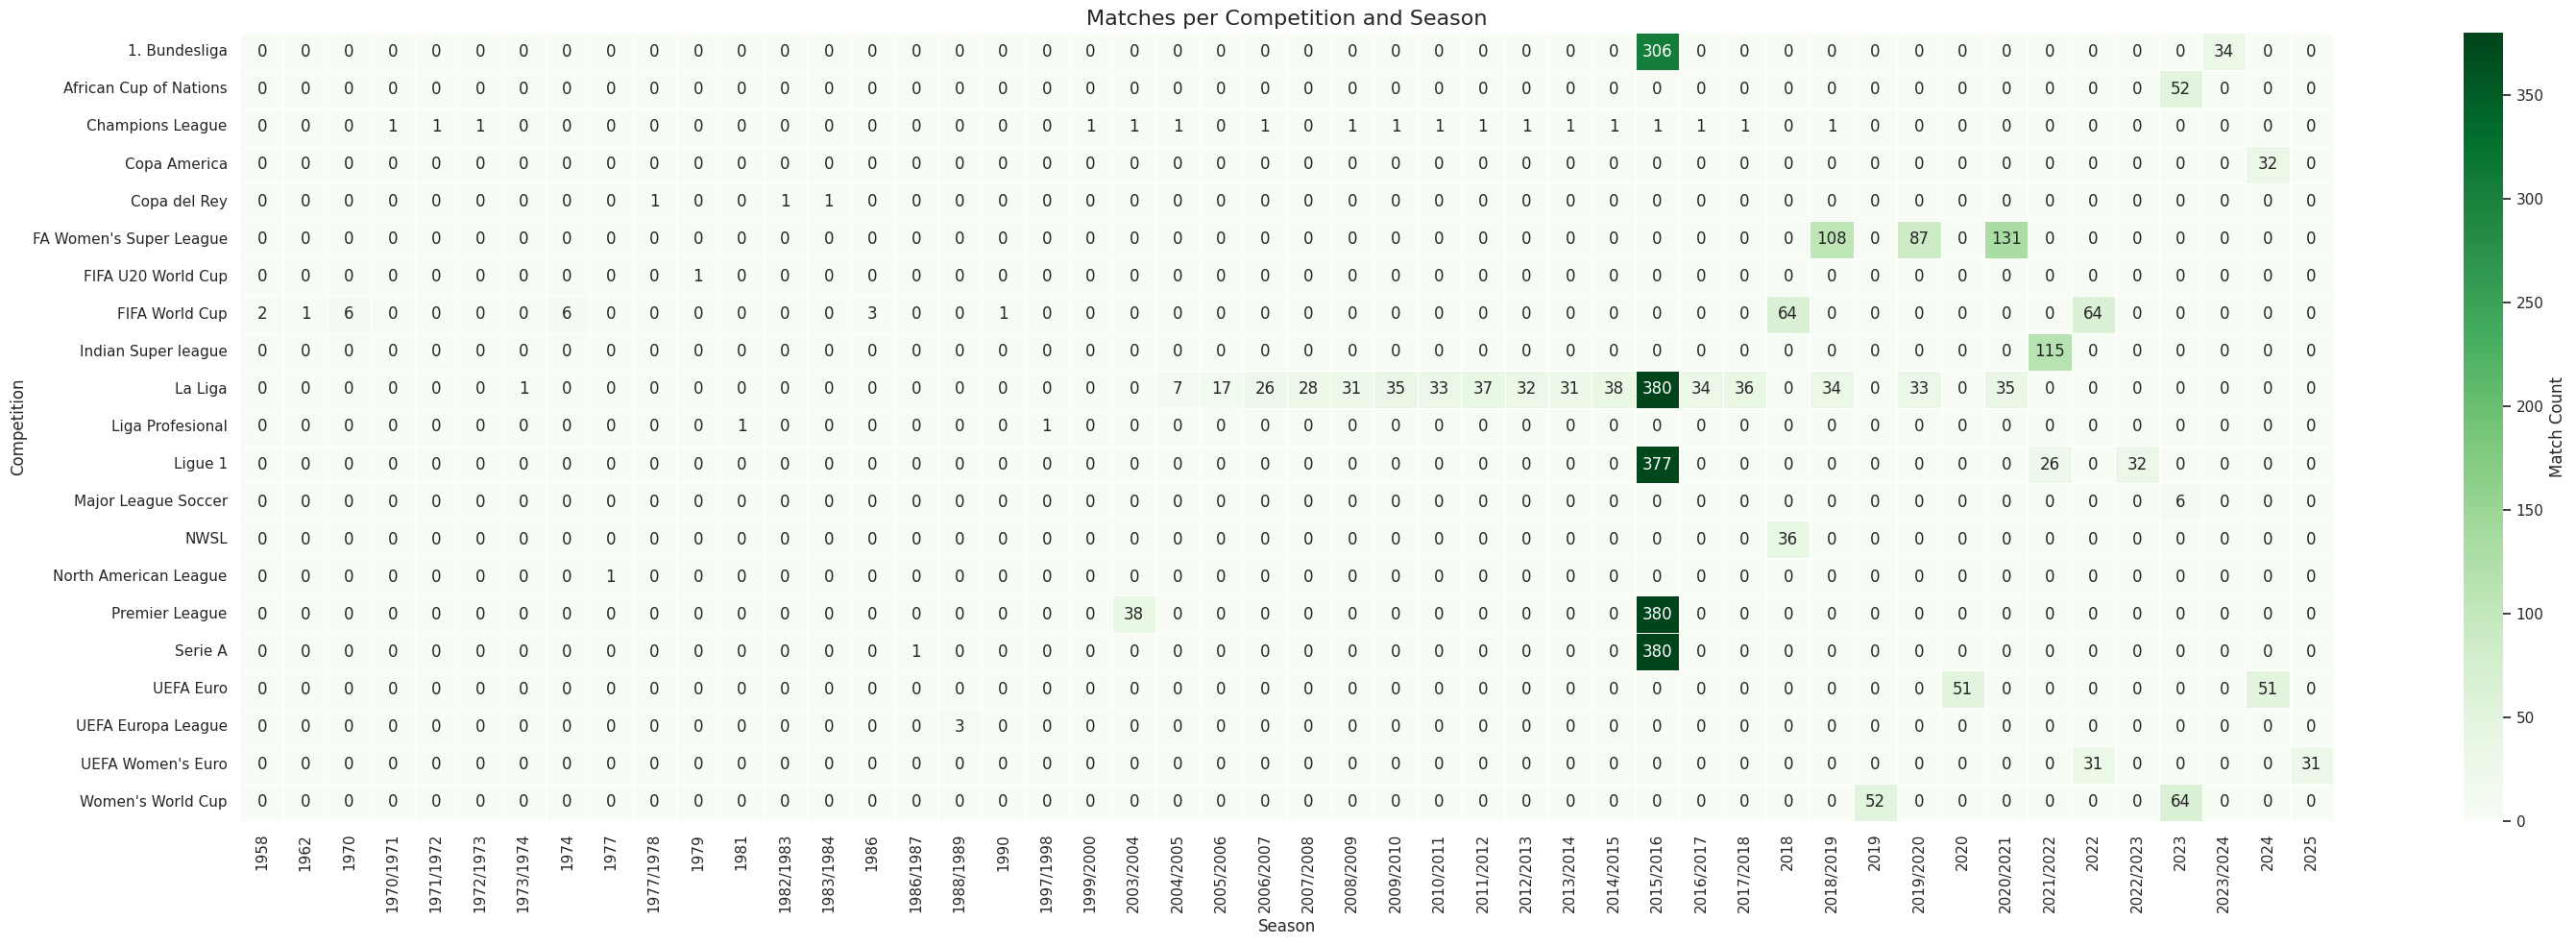

The project aims to address the following questions:

* How does explicitly modeling predictive uncertainty influence the accuracy and interpretability of xG estimates?
* Can uncertainty quantification reveal differences between players or shot types that point estimates overlook?
* How do probabilistic models compare to standard approaches in supporting practical football applications such as scouting, tactical design, and player development?

To answer these questions, the project compares probabilistic and non-probabilistic methods, evaluating their performance and the additional insights gained from uncertainty measures. The analysis explores how this richer information can distinguish players who consistently create high-quality chances from those with more volatile performance, ultimately enabling better-informed recruitment, lineup, and tactical decisions.

 Using the StatsBomb event data, all recorded shots are processed to construct feature representations that capture spatial, contextual, and tactical aspects of chance creation. These features are then used to train both traditional point-estimate models, such as logistic regression, and probabilistic approaches, including Bayesian logistic regression and Bayesian neural networks.

**TO DO: Blend two texts and add links**


## 2. Data Loading and Exploration

- Code to load data
- Basic exploration (plots, statistics, missing data, etc.)  




- Explain Data used. Where and how to access them? Are there special features (e.g. like freeze frame)
- How to access the data? Which tools are available?
- Which columns are useful?
- Where were the data stored? With links


The data used in the project originate from the publicly available StatsBomb Open Data repository, which is hosted on GitHub at [https://github.com/statsbomb/open-data](https://github.com/statsbomb/open-data). As stated in the introduction, StatsBomb provides detailed event-level data for over 3000 matches from more than 20 competitions. For every match, the event interface returns four primary dataframes. The first, `df_event`, contains the event log, including actions such as passes, shots and tackles. The second, `df_related`, links events to other, contextually associated actions. For instance, a shot may be related to a goalkeeper save or a block, with these connections captured through event identifiers. The third, `df_freeze`, provides freeze-frame data for each shot, recording the positions of all relevant players and the ball at the precise moment the shot is taken. Finally, `df_tactics` documents the tactical setups and line-ups for both teams at the start of the match. Together, these dataframes provide both the chronological sequence of match events and the contextual information needed for more advanced analyses. **(Quelle einfügen)**

For the project, the primary focus is on shot events extracted from the event data supplemented with their corresponding freeze-frame snapshots. The backbone `df_event` therby includes a wide range of columns describing every recorded action in a match. Figure X shows the frequncy of event types for Leipzigs match against Leverkusen from the 2023/2024 season.

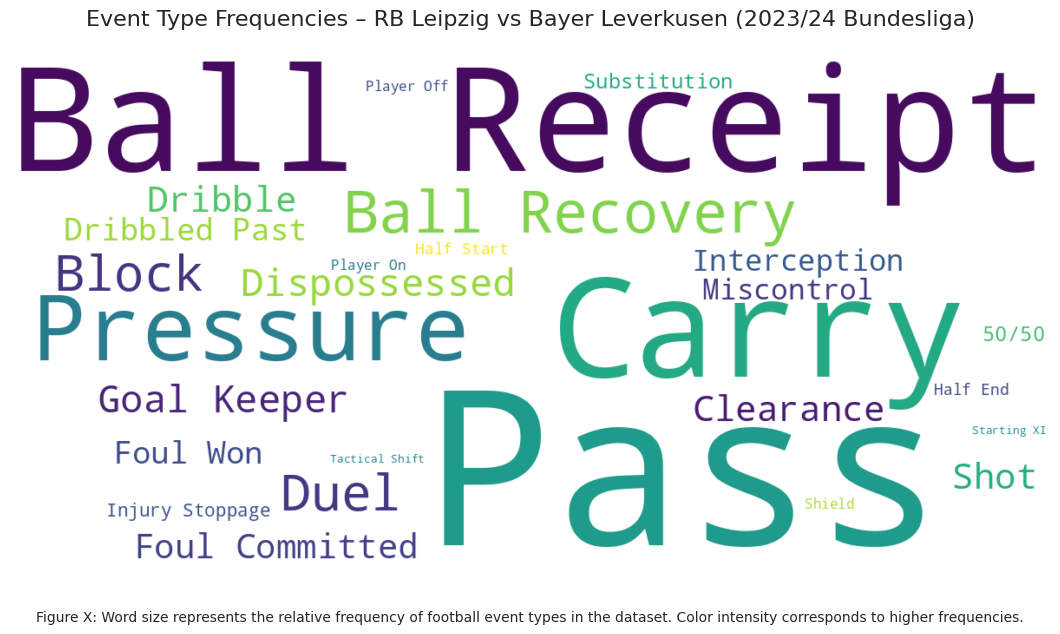

From the complete set of event data columns, only a subset is useful for shot analysis in the context of expected goals modelling, as numerous fields are not applicable to this event type and therefore empty. Table 1 summarises the retained columns, grouped by functional category.

| **Category**               | **Variables** | **Description** |
|----------------------------|---------------|-----------------|
| **Identifiers**            | `id`, `index`, `match_id` | Unique identifiers for the event, its order in the match, and the match itself. |
| **Temporal information**   | `period`, `timestamp` | Match period and exact time of the shot. |
| **Team & player**          | `team_id`, `team_name`, `player_id`, `player_name`, `position_id`, `position_name` | Identifies the shooting team, player, and their position at the time of the shot. |
| **Location data**          | `x`, `y`, `end_x`, `end_y`, `end_z` | Pitch coordinates of the shot and the end location of the ball’s trajectory (StatsBomb units). |
| **Shot execution details** | `body_part_id`, `body_part_name`, `technique_id`, `technique_name`, `sub_type_id`, `sub_type_name`, `shot_statsbomb_xg`, `shot_key_pass_id` | Categorisation of shot method, body part used, specific type, expected goals value, and link to preceding key pass. |
| **Contextual indicators**  | `under_pressure`, `off_camera`, `out`, `aerial_won`, `shot_first_time`, `shot_one_on_one`, `shot_deflected`, `shot_open_goal`, `shot_redirect`, `shot_follows_dribble` | Boolean indicators capturing situational or execution-specific context. |
| **Outcome**                | `outcome_id`, `outcome_name` | Result of the shot (e.g., goal, saved, blocked). |
| **Additional context**     | `minute`, `second`, `duration`, `half_start_late_video_start`, `half_end_early_video_end`, `pass_backheel`, `possession`, `possession_team_id`, `possession_team_name`, `play_pattern_id`, `play_pattern_name` | Supplementary temporal and tactical context. |

To construct a unified dataset for model training, all shot events were collected from every match in every competition available in the StatsBomb repository. The custom data-loading script is based on the open-source [statsbombpy](https://github.com/statsbomb/statsbombpy) Python library, which provides functions to retrieve competitions, matches, lineups, and event data directly into `pandas` DataFrames.

The individual match-level shot dataframes were appended into a single shots_master_df **(Link einfügen)**. After concatenation, only the identified relevant columns were kept, resulting in a dataset containing only variables applicable to shots across all competitions. This ensured that subsequent modelling steps are based on a clean, relevant feature set.

Freeze-frame data provide a snapshot of all players’ positions and the ball location at the exact moment a shot is taken. Each shot event in the StatsBomb dataset includes a corresponding freeze-frame entry in the df_freeze dataframe, linked via the event’s unique id. This structure enables the retrieval of all relevant player objects for a specific shot, including attributes such as pitch coordinates (x, y), team affiliation (teammate), and positional role (position_name). For example, filtering df_freeze by a given shot id yields the spatial context for that event.

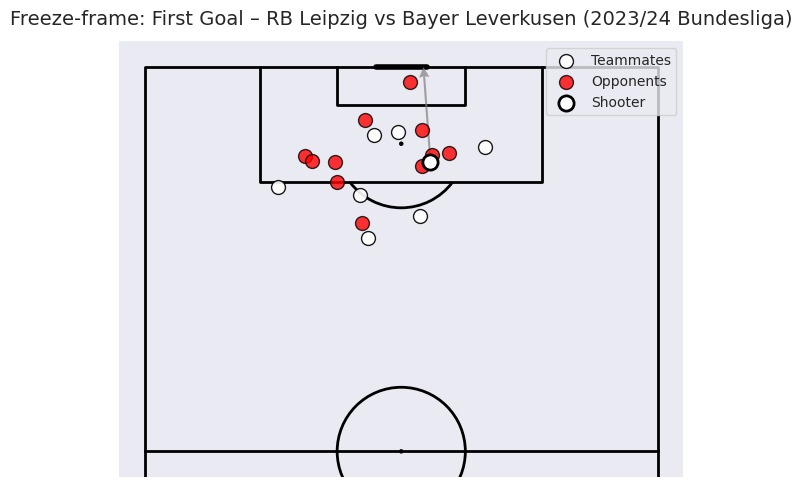


# 3. Data Preprocessing

- Steps taken to clean or transform the data



Following the identification of event-level variables relevant for shot analysis, the subsequent step involves deriving a set of explanatory features for modelling. This transformation process converts raw event and freeze-frame data into numerical and binary indicators that represent spatial relationships, tactical context and technical execution. The resulting feature set is designed to capture the primary factors hypothesised to influence shot outcomes, while maintaining a consistent representation across matches and competitions.


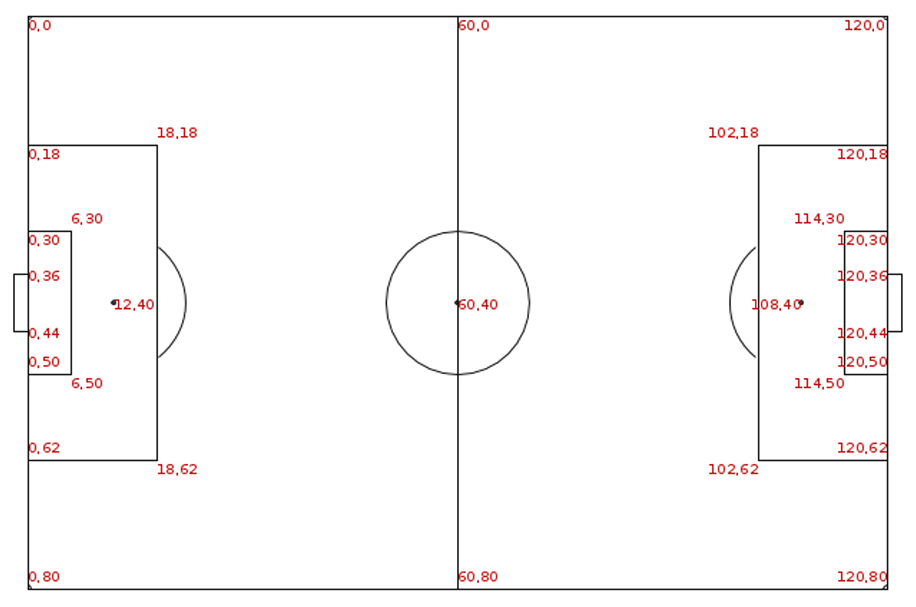

All positional quantities are expressed in pitch units (pu) according to the StatsBomb coordinate system ($120 \times 80$ pu for pitch length × width), thereby ensuring comparability without stadium-specific scaling. Additionally, in the StatsBomb coordinate system, all shots are standardised to a single attacking direction, ensuring consistent geometric feature calculation. The feature set is detailed below.

**1. Numerical features**

Let $i$ index shots.
Shots are standardised to a single attacking direction,

- **Distance to goal** (`distance_to_goal`)  
  Euclidean distance from the shot location $\mathbf{s}_i=(x_i,y_i)$ to the goal centre $\mathbf{g}=(120,40)$:  
  $$
  d_i = \sqrt{(x_i - 120)^2 + (y_i - 40)^2} \quad [\text{pu}].
  $$  
  This metric captures the proximity of the shooter to the goal; lower values correspond to closer shooting positions and are typically associated with higher scoring probability.

- **Angle to goal** (`angle_to_goal_deg`)  
  Opening angle $\theta_i$ subtended by the goalposts $\mathbf{p}_\mathrm{L}=(120,36)$ and $\mathbf{p}_\mathrm{R}=(120,44)$ at $\mathbf{s}_i$:  
  Let  
  $$
  a = \lVert \mathbf{s}_i - \mathbf{p}_\mathrm{L} \rVert_2, \quad
  b = \lVert \mathbf{s}_i - \mathbf{p}_\mathrm{R} \rVert_2, \quad
  c = 8\ \text{pu}
  $$  
  where $c$ is the official goal width in StatsBomb units. Then  
  $$
  \theta_i = \arccos\!\left( \frac{a^2 + b^2 - c^2}{2ab} \right), \quad
  \theta_i^{(\circ)} = \frac{180}{\pi}\theta_i.
  $$  
  Larger angles indicate more central shooting positions with greater visible goal area.


- **Opponents in way** (`opponents_in_way`)  
  Count of opposition players located within the *shooting triangle* defined by the shooter’s location and the two goalposts. Player positions are obtained from the freeze-frame data for the corresponding shot and tested for inclusion within the triangle using a barycentric sign method **(Quelle einfügen)**.

- **Teammates in way** (`teammates_in_way`)  
  Count of players on the shooter’s own team whose positions fall within the same shooting triangle. Although not defensive obstacles, such players may partially obscure the goalkeeper’s view or affect defensive positioning.

- **With dominant foot** (`with_dominant_foot`)  
  Binary indicator taking the value `1` if the recorded shot body part corresponds to the shooter’s dominant foot, and `0` otherwise. **(Erklären woher die Info kommt, wo die flaws liegen etc.)**

**2. Binary features**  

This group comprises indicator variables ($0 =$ false, $1 =$ true) capturing the situational context of the shot, its execution technique, the phase of play, and the body part used. All variables are derived from categorical fields in the StatsBomb event data and represented using one-hot encoding where applicable.

**Shot context**  
- `shot_first_time` — Shot taken without controlling the ball prior to execution.  
- `shot_one_on_one` — Shooter in direct confrontation with the goalkeeper, without an intervening defender.  
- `shot_open_goal` — Goalkeeper absent from a position to make a save.  

**Technique**  
- `technique_Backheel`  
- `technique_Diving Header`  
- `technique_Half Volley`  
- `technique_Lob`  
- `technique_Normal`  
- `technique_Overhead Kick`  
- `technique_Volley`  
Each variable flags the presence of the corresponding shooting technique.  

**Phase of play**  
- `subtype_Free Kick` — Direct shot taken from a free kick.  
- `subtype_Open Play` — Shot occurring during continuous play.  
- `subtype_Penalty` — Penalty kick taken from the spot.  

**Body part**  
- `is_header` — Shot executed with the head.  

The final dataset including all features is stored here **(Einfügen)**

## 4. Probabilistic Modeling Approach

- Description of the models chosen
- Why they are suitable for your problem
- Mathematical formulations (if applicable)



As stated in the introduction, the objective of this project is to estimate the probability that a given shot results in a goal as a function of spatial, contextual, and categorical features. One central aim of the work is to evaluate whether explicitly modelling predictive uncertainty can enhance the accuracy and interpretability of expected goals estimates and whether such uncertainty measures provide additional insights into differences between players, shot types, or match contexts. To address these objectives, three complementary model classes are employed. Logistic Regression (LR) serves as a transparent and interpretable baseline, offering a well-established benchmark in football analytics for relating shot features to scoring probability. **(Quelle einfügen)** Bayesian Logistic Regression (BLR) extends this foundation by introducing parameter uncertainty, allowing the model to express confidence in its estimates. Bayesian Neural Networks (BNN) further enhance modelling capacity by capturing complex nonlinear relationships between features, such as interactions between shooting angle, shot technique and body part used, while still producing predictive distributions. Together, these models provide a spectrum from interpretability and simplicity to flexibility and expressive power, enabling an evaluation of probabilistic approaches in the expected goals context.

###Logistic Regression  
Logistic regression serves as a transparent, interpretable baseline model. Given a feature vector $\mathbf{x}_i$ for shot $i$, the goal probability is modelled as:

$$
p(y_i = 1 \mid \mathbf{x}_i) = \sigma(\mathbf{w}^\top \mathbf{x}_i) = \frac{1}{1 + e^{-\mathbf{w}^\top \mathbf{x}_i}}
$$

where $y_i \in \{0,1\}$ indicates goal outcome and $\mathbf{w}$ is the vector of learned coefficients.  
Logistic Regression is widely used in football analytics due to its computational efficiency and the direct interpretability of its parameters, which indicate how each feature affects the log-odds of scoring.

###Bayesian Logistic Regression
BLR extends the frequentist LR by introducing a prior distribution over model parameters, for example:

$$
\mathbf{w} \sim \mathcal{N}(\mathbf{0}, \tau^2 \mathbf{I})
$$

Posterior inference is then performed via Bayes’ theorem:

$$
p(\mathbf{w} \mid D) \propto p(D \mid \mathbf{w}) \, p(\mathbf{w})
$$

where $D$ denotes the training data. Predictions marginalise over the posterior:

$$
p(y_i = 1 \mid \mathbf{x}_i, D) = \int \sigma(\mathbf{w}^\top \mathbf{x}_i) \, p(\mathbf{w} \mid D) \, d\mathbf{w}
$$

This approach captures parameter uncertainty, translating it into predictive uncertainty and allows the model to express its confidence (or lack thereof) in the estimated goal probabilities.

###Bayesian Neural Networks
BNNs generalise the Bayesian approach to flexible, nonlinear models. The linear mapping of LR is replaced by a multi-layer feedforward neural network:

$$
\mathbf{h}^{(1)} = \phi(\mathbf{W}^{(1)} \mathbf{x} + \mathbf{b}^{(1)}), \quad
\hat{y} = \sigma(\mathbf{W}^{(L)} \mathbf{h}^{(L-1)} + \mathbf{b}^{(L)})
$$

where each weight matrix $\mathbf{W}^{(l)}$ and bias vector $\mathbf{b}^{(l)}$ has a prior distribution, and approximate inference (e.g., variational Bayes, Monte Carlo dropout) is used to estimate the posterior.  
BNNs can model complex interactions between features while still producing full predictive distributions.


These probabilistic models are particularly appropriate for expected goals estimation because they provide both a point prediction and a measure of uncertainty. Two shots with the same mean xG can differ greatly in variance depending on factors such as defensive pressure or shooting technique. By modelling uncertainty explicitly, it becomes possible to distinguish between consistent chance creation and volatile, high-risk opportunities, supporting more informed decision-making in scouting, tactics, and player development.


# 5. Model Training and Evaluation

- Training process
- Model evaluation (metrics, plots, performance)
- Cross-validation or uncertainty quantification



## 5. Training and Evaluation

### 5.1 Data Preparation
Model training was performed on the processed dataset of shot events described in Section&nbsp;3, with the binary target variable $y$ indicating whether the shot resulted in a goal ($y=1$) or not ($y=0$).  
The feature set comprised spatial, contextual, and categorical indicators, with categorical variables encoded using one-hot encoding and all numerical features standardised to zero mean and unit variance.  
Missing values were handled according to feature type: binary indicators were set to `0` (false), numerical variables were imputed with feature-wise means, and categorical fields were encoded as all-zero vectors when missing.  
To preserve comparability across folds and prevent data leakage, all preprocessing steps were fitted on the training data within each cross-validation split and applied to the corresponding validation data.

The dataset is **class-imbalanced**, with goals representing only a small proportion of all shots.  
This imbalance was addressed in two ways:
1. **Stratified cross-validation** ensured that each fold preserved the original proportion of goals and non-goals.
2. **Class weighting** in model training penalised misclassification of goals more heavily, reducing the bias toward predicting the majority class.

---

### 5.2 Training Procedure
A **stratified 5-fold cross-validation** strategy was used to ensure that each fold preserved the proportion of goals and non-goals.  
In each iteration, models were trained on $k-1$ folds and evaluated on the remaining fold, cycling until every fold had served as the validation set.  
This produced distributions of performance metrics across folds, enabling assessment of both central tendency and variability.

- **Logistic Regression (LR)**: trained via maximum likelihood estimation using the scikit-learn implementation, with L2 regularisation strength selected via grid search on the training folds. Class weights were applied inversely proportional to class frequencies.  
- **Bayesian Logistic Regression (BLR)**: parameters inferred using variational Bayes with a Gaussian prior on coefficients; inference was implemented with PyMC, and posterior samples were drawn to enable uncertainty estimation. Class imbalance was addressed through balanced sampling within mini-batches.  
- **Bayesian Neural Network (BNN)**: implemented as a feedforward network with ReLU activations, trained using Adam optimisation. Monte Carlo dropout was applied at both training and test time to generate approximate posterior samples over network weights. Class imbalance was handled using a weighted loss function to emphasise correct classification of goals.

Hyperparameters for BLR and BNN (e.g., prior variance, learning rate, dropout rate, number of hidden units) were tuned using nested cross-validation within the training folds.

---

### 5.3 Evaluation Metrics

Model performance was assessed using a combination of discrimination, probabilistic scoring, and calibration metrics, supported by visual diagnostics.

- **Area Under the Receiver Operating Characteristic Curve (AUC)**  
  Measures the model’s ability to discriminate between goals and non-goals across all possible probability thresholds.  
  An AUC of 0.5 corresponds to random guessing, while 1.0 indicates perfect discrimination.

- **Accuracy**  
  Proportion of correctly classified outcomes when applying a default decision threshold of 0.5.  
  While intuitive, accuracy can be misleading in imbalanced datasets such as this one — where goals represent only a small fraction of all shots — because high accuracy can be achieved by always predicting the majority class.  
  For this reason, accuracy is reported for completeness but is not the primary evaluation criterion.

- **Log-Loss**  
  Measures the mean cross-entropy between predicted probabilities and actual outcomes, penalising overconfident or poorly calibrated predictions:  
  $$
  \text{LogLoss} = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log \hat{p}_i + (1 - y_i) \log (1 - \hat{p}_i) \right]
  $$  
  Lower values indicate better alignment between predicted probabilities and observed frequencies.

- **Brier Score**  
  Computes the mean squared error between predicted probabilities and actual binary outcomes:  
  $$
  \text{Brier} = \frac{1}{N} \sum_{i=1}^N (\hat{p}_i - y_i)^2
  $$  
  This metric is directly interpretable as the average squared deviation of predicted probabilities from observed outcomes, with lower values indicating better probability calibration.

- **Calibration Analysis**  
  Since this study explicitly models predictive uncertainty, calibration is a key evaluation aspect.  
  Calibration curves (reliability diagrams) were plotted to compare predicted goal probabilities against observed goal frequencies in binned probability ranges.  
  The **Expected Calibration Error (ECE)** was computed to summarise miscalibration as the weighted average of the absolute difference between predicted and empirical probabilities across bins.  
  Well-calibrated models produce curves close to the diagonal and low ECE values.

In addition to these scalar metrics, two threshold-dependent visual diagnostics were used:
- **Receiver Operating Characteristic (ROC) curves** to visualise the trade-off between true positive and false positive rates across thresholds.
- **Precision–Recall (PR) curves** to illustrate model performance in identifying rare events (goals) where class imbalance can make ROC curves overly optimistic.

To address the imbalance between goals and non-goals, all models were trained with class weighting, assigning greater weight to the rarer goal class in the loss function.


---

### 5.4 Uncertainty Quantification
For the Bayesian models (BLR and BNN), **predictive uncertainty** was estimated by generating multiple posterior predictive samples for each shot:

- **BLR**: posterior draws of model coefficients were used to compute corresponding predicted probabilities, from which the standard deviation across samples was taken as the uncertainty measure.
- **BNN**: multiple stochastic forward passes with dropout enabled at test time provided an empirical distribution of predicted probabilities for each shot; the standard deviation served as the uncertainty measure.

This procedure yielded not only mean probability estimates but also shot-level measures of predictive confidence, enabling direct comparisons of uncertainty across shot types, distances, and angles.

---

### 5.5 Outputs for Results
From each cross-validation fold, the following outputs were retained for analysis in Section&nbsp;6:
- Distributions of performance metrics (Brier score, log loss, ROC-AUC, ECE).
- Predicted probability vectors for calibration plots and precision–recall analysis.
- Predictive uncertainty values for BLR and BNN, enabling later exploration of confidence patterns across contexts.


# 6. Results

- Present key findings
- Comparison of models if multiple approaches were used



**Performance Summary Table**

| Model                  | AUC   | Accuracy | Log-Loss |
|------------------------|-------|----------|----------|
| Logistic Regression    | 0.807 | 0.761    | 0.523    |
| Bayesian Logistic Reg. | 0.805 | 0.902    | 0.277    |
| Bayesian Neural Net    | 0.813 | 0.904    | 0.271    |



Three models were evaluated on the held-out test set: a baseline (frequentist) logistic regression (LR), a Bayesian logistic regression (BLR), and a Bayesian neural network (BNN).  
The baseline LR achieved an AUC of **0.807**, an accuracy of **0.761**, and a log-loss of **0.523**.  
The BLR improved upon this, with an AUC of **0.805**, an accuracy of **0.902**, and a log-loss of **0.277**, demonstrating that incorporating parameter uncertainty can lead to substantially better calibration and accuracy without sacrificing ranking ability.  
The BNN achieved the highest overall performance, with an AUC of **0.813**, an accuracy of **0.904**, and a log-loss of **0.271**. These results indicate that the BNN’s additional flexibility allows it to capture more complex patterns in the data while maintaining strong probability calibration.  

Uncertainty analysis further differentiates the models. The baseline LR produces point estimates without quantifying parameter uncertainty. In contrast, both Bayesian approaches generate credible intervals for predictions, reflecting the posterior uncertainty over parameters. The BLR’s intervals are generally narrower, reflecting its simpler linear form, whereas the BNN’s intervals can be wider for certain samples, especially in regions of the feature space with less training data coverage. This suggests that the BNN is able to signal when it is less certain about a prediction — a desirable property in risk-sensitive applications.  

Overall, the Bayesian approaches outperform the baseline LR in terms of calibration and, for the BNN, also in discrimination (AUC). The BNN provides the richest uncertainty quantification, but at the cost of higher computational demand, while the BLR strikes a balance between performance, interpretability, and efficiency.

# 7. Discussion

- Interpretation of results
- Limitations of the approach
- Possible improvements or extensions



### Interpretation of Results
The comparison between the baseline logistic regression, Bayesian logistic regression (BLR), and Bayesian neural network (BNN) shows a clear performance improvement when Bayesian methods are applied.  
While the baseline LR achieved an AUC of 0.807 and an accuracy of 0.761, the BLR substantially increased accuracy to 0.902 and reduced log-loss from 0.523 to 0.277, indicating much better probability calibration.  
The BNN achieved the highest AUC (0.813) and slightly higher accuracy (0.904) compared to the BLR, with the lowest log-loss (0.271).  
Uncertainty analysis revealed that Bayesian models provide credible intervals for predictions, allowing the detection of low-confidence cases. The BNN captured more complex patterns in the data, which is beneficial for tasks where feature interactions are nonlinear.

### Limitations of the Approach
- **Computational cost**: Bayesian inference, especially for neural networks, is significantly more computationally expensive than frequentist methods.
- **Model complexity**: The BNN’s additional parameters improve flexibility but also increase the risk of overfitting, particularly with limited data.
- **Interpretability**: BLR retains a degree of interpretability through its coefficients, whereas BNNs are more opaque.
- **Data dependence**: Performance gains depend on the representativeness of the training data; Bayesian methods still rely on quality and diversity of the input.

### Possible Improvements or Extensions
- **More efficient inference**: Use variational inference or other approximate methods to speed up sampling for larger networks.
- **Feature engineering**: Incorporate domain knowledge to create more informative features, potentially improving all models.
- **Hierarchical models**: Extend the Bayesian framework to include hierarchical priors for capturing group-level effects.
- **Model ensembles**: Combine multiple Bayesian models to further improve robustness and predictive performance.
- **Calibration analysis**: Perform deeper calibration checks (e.g., reliability diagrams) to better understand the probability estimates.


# 8. Conclusion

- Summary of main outcomes



This study compared three approaches to binary classification: a baseline logistic regression, a Bayesian logistic regression (BLR), and a Bayesian neural network (BNN).  
The results show that incorporating Bayesian inference improves both predictive performance and probability calibration.  
Compared to the baseline logistic regression (AUC: 0.807, Accuracy: 0.761, Log-Loss: 0.523), the BLR substantially improved accuracy (0.902) and reduced log-loss (0.277), while maintaining a comparable AUC (0.805).  
The BNN achieved the highest AUC (0.813), slightly higher accuracy (0.904), and the lowest log-loss (0.271), indicating the best overall performance among the three.  

In addition to performance gains, both Bayesian models provide uncertainty estimates through credible intervals, allowing more informed decision-making in cases of low confidence. The BNN, with its capacity to model nonlinear feature interactions, offers the richest uncertainty quantification but at the cost of increased computational demands.  
The BLR strikes a balance between performance, interpretability, and efficiency, making it a strong candidate for scenarios where model transparency is essential.  

Overall, the findings support the use of Bayesian methods for improving model reliability and decision-making, especially in applications where understanding uncertainty is as important as achieving high predictive accuracy.


# 9. References

- Cite any papers, datasets, or tools used

- StatsBomb (2025). *StatsBomb Open Data*. GitHub repository: [https://github.com/statsbomb/open-data](https://github.com/statsbomb/open-data)  
  Dataset containing detailed football event data, including freeze-frame information for shots.

- Neal, R. M. (2012). *Bayesian Learning for Neural Networks*. Springer Science & Business Media.  
  Foundational work on Bayesian neural networks.

- Bishop, C. M. (2006). *Pattern Recognition and Machine Learning*. Springer.  
  Comprehensive reference for probabilistic modelling and machine learning theory.

- Brier, G. W. (1950). *Verification of Forecasts Expressed in Terms of Probability*. Monthly Weather Review, 78(1), 1–3.  
  Original description of the Brier score metric.

- Murphy, K. P. (2012). *Machine Learning: A Probabilistic Perspective*. MIT Press.  
  Detailed coverage of Bayesian logistic regression and probabilistic inference methods.

- Pedregosa, F., Varoquaux, G., Gramfort, A., et al. (2011). *Scikit-learn: Machine Learning in Python*. Journal of Machine Learning Research, 12, 2825–2830.  
  Library used for logistic regression and evaluation metrics.

- StatsBombPy (2025). *Python client for StatsBomb data*. GitHub repository: [https://github.com/statsbomb/statsbombpy](https://github.com/statsbomb/statsbombpy)  
  Tool for loading and processing StatsBomb Open Data in Python.

- Kingma, D. P., & Welling, M. (2014). *Auto-Encoding Variational Bayes*. arXiv preprint arXiv:1312.6114.  
  Methodology underlying variational inference for Bayesian models.

- Gal, Y., & Ghahramani, Z. (2016). *Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning*. In *Proceedings of the 33rd International Conference on Machine Learning (ICML)*.  
  Approach used for Monte Carlo dropout in Bayesian neural networks.
